<a href="https://colab.research.google.com/github/JunhOpportunity/AI_lab/blob/main/week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
PyTorch version: 2.8.0+cu126
Dataset Information:
Number of samples: 20640
Number of features: 8

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)

Target statistics:
  Min: $14999.00
  Max: $500001.00
  Mean: $206855.82
Training set size: 16512 samples
Test set size: 4128 samples

✓ Data normalized (mean=0, std=1)
Batch size: 64
Number of training batches: 258
Number of test batches: 65
RegressionModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda
Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001
Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 0.3203 | Test Loss: 0.3235
Epoch [20/100] | Train Loss:

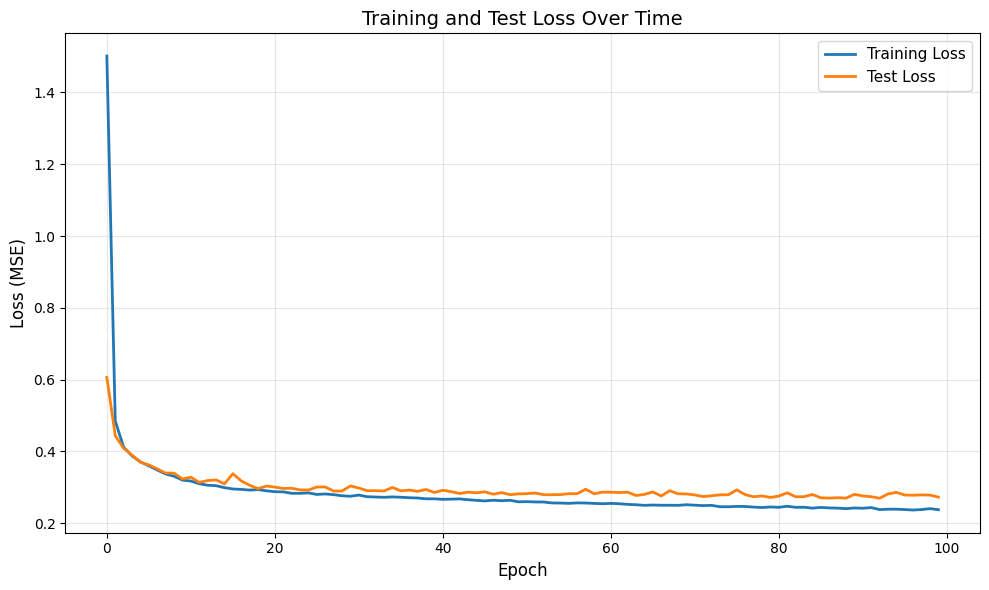

Final Training Loss: 0.2378
Final Test Loss: 0.2728
Model Performance on Test Set:
Mean Squared Error (MSE):  0.2733
Root Mean Squared Error (RMSE): 0.5227
Mean Absolute Error (MAE): 0.3569
R² Score: 0.7915

Interpretation:
On average, predictions are off by $35689.19
Model explains 79.15% of the variance in house prices


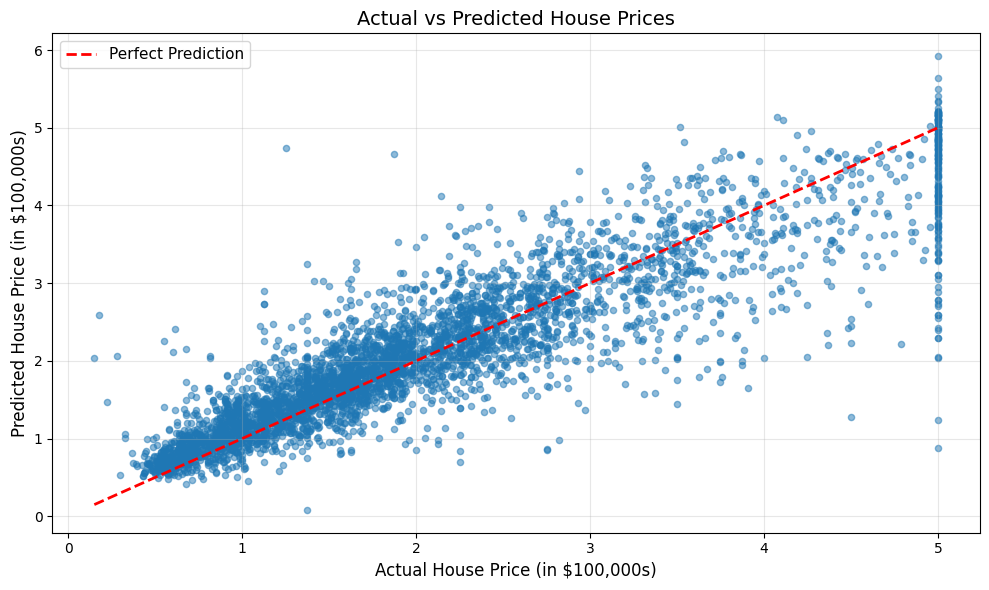


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
$    47,700 | $    58,942 | $   -11,242
$    45,800 | $    73,624 | $   -27,824
$   500,001 | $   460,492 | $    39,509
$   218,600 | $   245,022 | $   -26,422
$   278,000 | $   292,612 | $   -14,612
$   158,700 | $   171,338 | $   -12,638
$   198,200 | $   235,478 | $   -37,278
$   157,500 | $   175,265 | $   -17,765
$   340,000 | $   236,978 | $   103,022
$   446,600 | $   466,467 | $   -19,867
✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

##################################################
# Load California Housing dataset
data = fetch_california_housing()

# Extract features and target
X = data.data
y = data.target

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {data.feature_names}")
print(f"Target: Median house value (in $100,000s)")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: ${y.min() * 100000:.2f}")
print(f"  Max: ${y.max() * 100000:.2f}")
print(f"  Mean: ${y.mean() * 100000:.2f}")

##################################################

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

###################################

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

####### Model Definition ######
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

####### Loss Function and Optimizer ######

# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

####### Training Loop #######

# Training parameters
num_epochs = 100

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Price (in $100,000s)', fontsize=12)
plt.ylabel('Predicted House Price (in $100,000s)', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0] * 100000
    predicted = y_pred[i][0] * 100000
    diff = actual - predicted
    print(f"${actual:>10,.0f} | ${predicted:>10,.0f} | ${diff:>10,.0f}")

# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


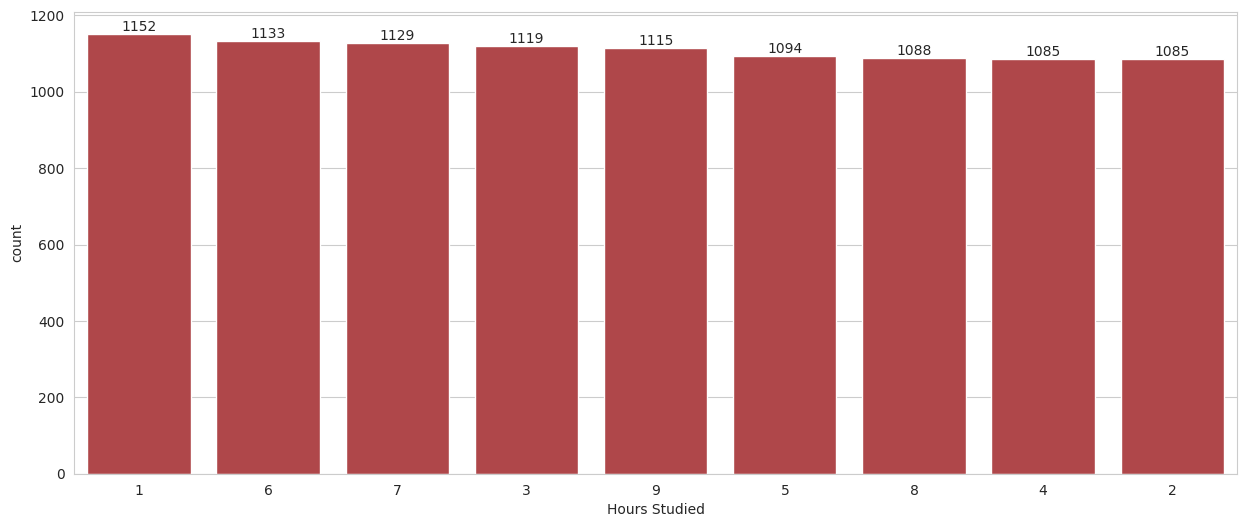

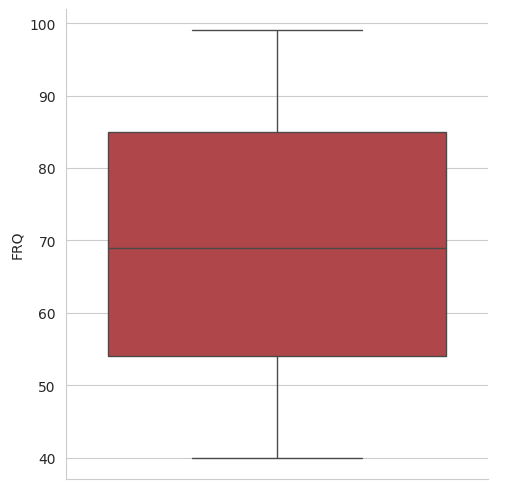

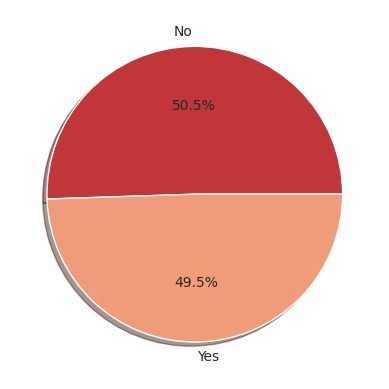

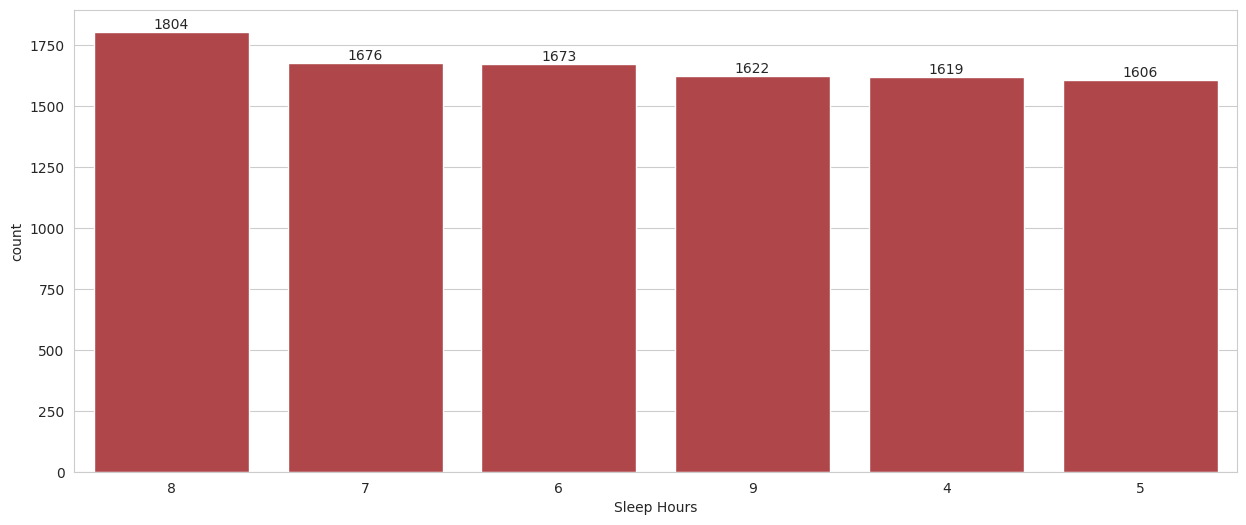

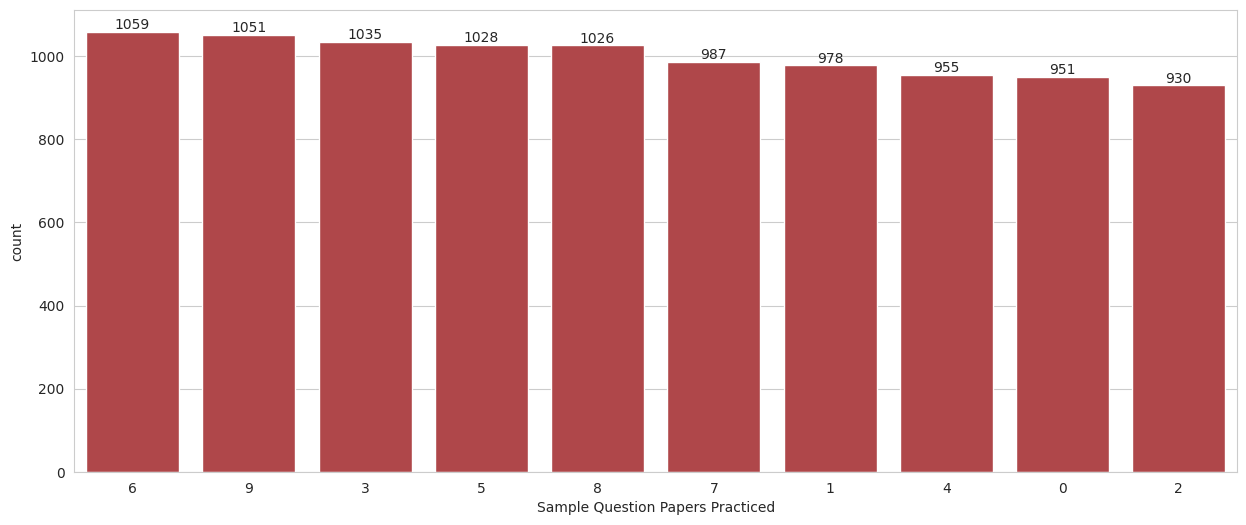

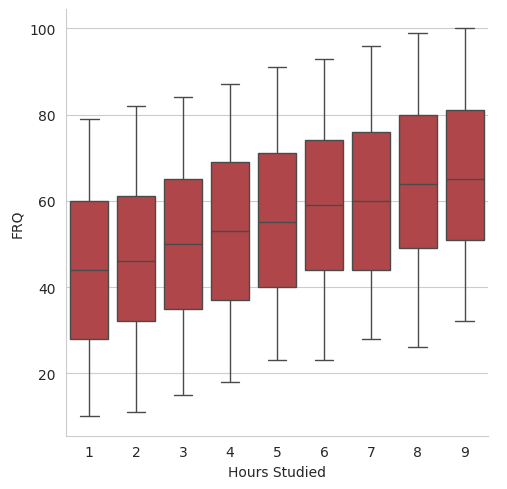

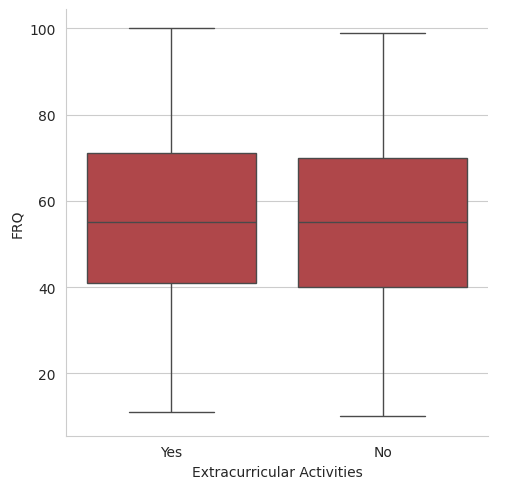

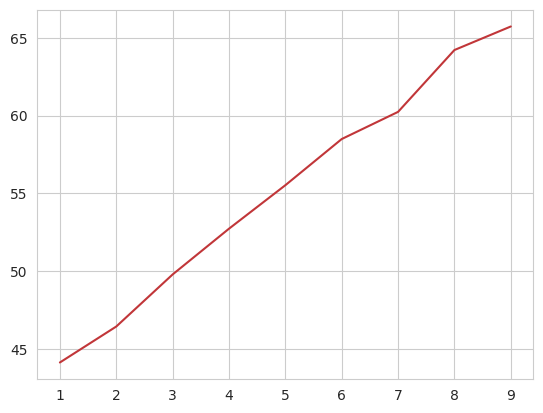

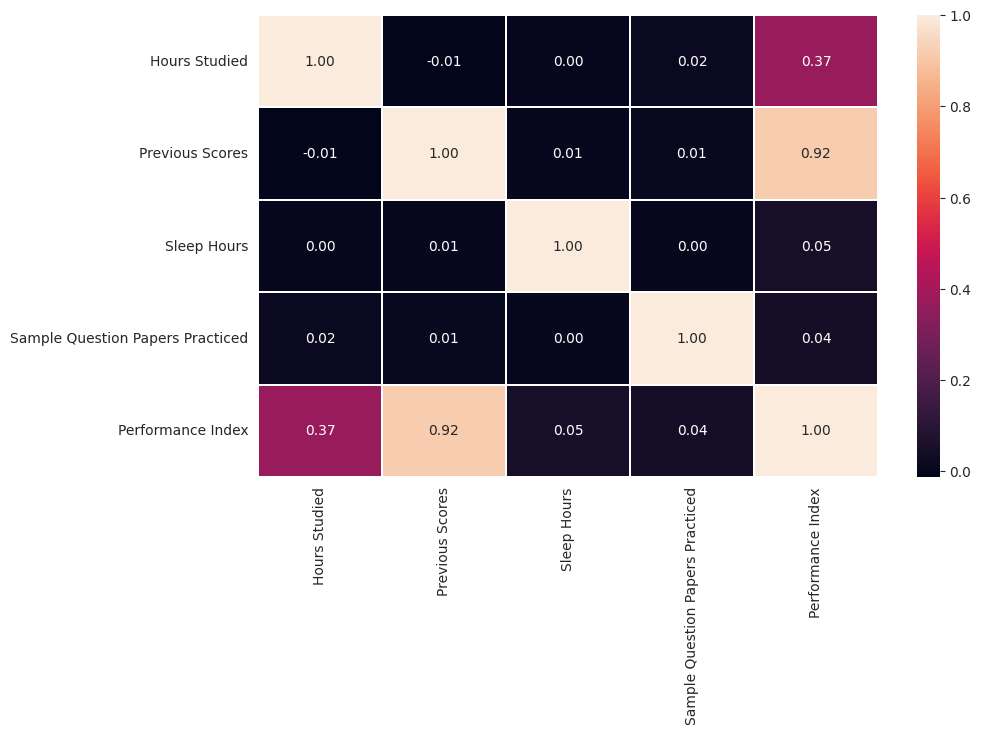

x_train shape:  (8000, 5)
y_train shape:  (8000,)
x_test shape:  (2000, 5)
y_test shape:  (2000,)


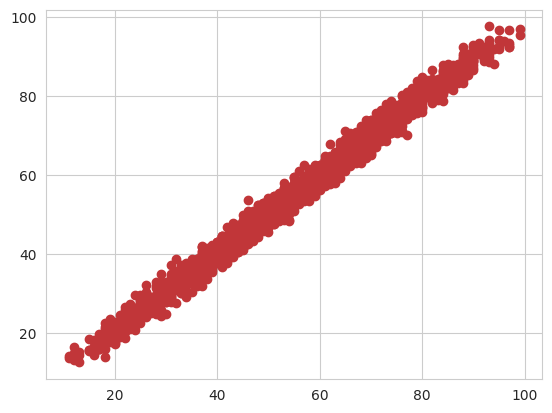

np.float64(-33.92194621555638)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set style of visualization
sns.set_style("whitegrid")
sns.set_palette("RdBu")

data = pd.read_csv("/content/Student_Performance.csv")

data.head()

data.info()

data.isna().sum() / data.shape[0]

data.shape

data.duplicated().any()

data.describe()

data.describe(include = object)

# create function to visualized categorical column using count plot

def count_plot(column_name, hue = None, rotation = 0):
    """
    1) input : column name, column data type must be object or categorical
    3) output : cout plot using seaborn modules, unique values in x-axis and frequency in y-axis
    4) i use bar_label to show frequency of each unique values above each column in graph
    """
    graph = sns.countplot(x = column_name, data = data, hue = hue, order = data[column_name].value_counts().index)
    for container in graph.containers:
        graph.bar_label(container)


    plt.xticks(rotation = rotation)
    plt.show()

def box_plot(x_axis = None, y_axis = None, hue = None, col = None):
    """
    input : x_axis, y_axis and hue column, column data type must be numeric in y_axis
    output : box plot to see distribution of column values such as min,max,mean,medien,std
    """
    sns.catplot(x = x_axis, y = y_axis, data = data, hue = hue, kind = "box", col = col)
    plt.xlabel(x_axis)
    plt.ylabel("FRQ")
    plt.show()

data["Hours Studied"].unique()


# first set figure size
plt.figure(figsize = (15,6))

# call function i create it in cell 10
count_plot(column_name = "Hours Studied")

box_plot(y_axis = "Previous Scores")

# see unique values

data["Extracurricular Activities"].unique()

plt.pie(data["Extracurricular Activities"].value_counts(), labels = data["Extracurricular Activities"].value_counts().index,
        shadow = True, autopct = "%1.1f%%")
plt.show()

data["Sleep Hours"].unique()

# first set figure size
plt.figure(figsize = (15,6))

# call function i create it in cell 10
count_plot(column_name = "Sleep Hours")

data["Sample Question Papers Practiced"].unique()

# first set figure size
plt.figure(figsize = (15,6))

# call function i create it in cell 10
count_plot(column_name = "Sample Question Papers Practiced")

box_plot(x_axis = "Hours Studied", y_axis = "Performance Index")

box_plot(x_axis = "Extracurricular Activities", y_axis = "Performance Index")

avg_performance_by_hours = data.groupby('Hours Studied')['Performance Index'].mean()
plt.plot(avg_performance_by_hours.index, avg_performance_by_hours.values)
plt.show()

plt.figure(figsize = (10,6))
sns.heatmap(data.select_dtypes(exclude = object).corr(), annot = True, fmt = ".2f", linewidths = 0.2)
plt.show()

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score

# create object from labelencoder

encoder = LabelEncoder()

data["Extracurricular Activities"] =  encoder.fit_transform(data["Extracurricular Activities"])

# see sample of data

data.sample(2)

Train = data.drop(columns = "Performance Index")
Target = data["Performance Index"]

# see sample of train data

Train.sample(3)

Target

X_train, X_test, y_train, y_test = train_test_split(Train, Target, test_size = 0.2, random_state = 42)

print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

model = LinearRegression()

model.fit(X_train,y_train)

model.score(X_train, y_train)

predict = np.round(model.predict(X_test), decimals = 1)

pd.DataFrame({"Actual Performance" : y_test, "Predicted Performance" : predict})

plt.scatter(y_test, predict)
plt.show()

mean_absolute_error(y_test,predict)

r2_score(y_test,predict)

model.coef_
model.intercept_

